In [2]:
# Basic libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# CatBoost
from catboost import CatBoostRegressor

# Explainability
import shap

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

c:\Users\dheer\anaconda3\envs\Jobb\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
df = pd.read_csv("case_data.csv", encoding="utf-8")

In [10]:
print("Shape:", df.shape)
df.head(1)

Shape: (59310, 40)


,District,Address,Class,HouseNumber,Building,Plot,FloorsTotal,HandoverDate,Phase,BuildingType,...,LivingArea,KitchenArea,HallwayArea,BathroomArea,BalconyArea,PlotArea,PricePerMeter,TotalCost,Developer_encoded,Complex_encoded
0,МО Ленинский г.о.,"Сапроново д., Калиновая ул.",Комфорт,NaN,1,NaN,25,Сдан,1,Монолит,...,43.7,12.2,13.5,"3,4с+1,3т","3,4л",0.0,266300.0,20265430.0,Developer58,Complex0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59310 entries, 0 to 59309
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   District            59310 non-null  object 
 1   Address             59310 non-null  object 
 2   Class               59310 non-null  object 
 3   HouseNumber         1650 non-null   object 
 4   Building            59219 non-null  object 
 5   Plot                3061 non-null   object 
 6   FloorsTotal         59310 non-null  int64  
 7   HandoverDate        59310 non-null  object 
 8   Phase               59310 non-null  int64  
 9   BuildingType        59310 non-null  object 
 10  InstallmentUntil    5 non-null      object 
 11  InstallmentMonths   636 non-null    float64
 12  Number              59310 non-null  object 
 13  PIBNumber           136 non-null    object 
 14  LayoutType          93 non-null     object 
 15  Axis                0 non-null      float64
 16  Floo

In [12]:
drop_cols = [
    "Axis",
    "InstallmentUntil",
    "InstallmentMonths",
    "PIBNumber",
    "LayoutType",
    "HouseNumber",
    "Plot",
    "Address",
    "Number"
]

df = df.drop(columns=drop_cols)

print("New shape:", df.shape)

New shape: (59310, 31)


In [13]:
df.isnull().sum().sort_values(ascending=False).head(10)

Building        91
District         0
Class            0
FloorsTotal      0
HandoverDate     0
Phase            0
BuildingType     0
Floor            0
Section          0
PropertyType     0
dtype: int64

In [14]:
import re

def extract_numeric(value):
    if pd.isna(value):
        return np.nan
    numbers = re.findall(r"\d+\.\d+|\d+", str(value))
    if numbers:
        return sum(float(n) for n in numbers)
    return np.nan

df["BathroomArea"] = df["BathroomArea"].apply(extract_numeric)
df["BalconyArea"] = df["BalconyArea"].apply(extract_numeric)

In [15]:
area_columns = [
    "TotalArea",
    "AreaWithoutBalcony",
    "LivingArea",
    "KitchenArea",
    "HallwayArea",
    "BathroomArea",
    "BalconyArea",
    "PlotArea",
    "PricePerMeter",
    "TotalCost",
    "CeilingHeight"
]

for col in area_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

In [16]:
df.isnull().sum().sort_values(ascending=False).head(10)

Building        91
District         0
Class            0
FloorsTotal      0
HandoverDate     0
Phase            0
BuildingType     0
Floor            0
Section          0
PropertyType     0
dtype: int64

In [17]:
df["Building"] = df["Building"].fillna("Unknown")

In [18]:
df = df.dropna(subset=["PricePerMeter"])

In [19]:
upper_limit = df["PricePerMeter"].quantile(0.99)
df = df[df["PricePerMeter"] < upper_limit]

In [20]:
df["target"] = np.log(df["PricePerMeter"])

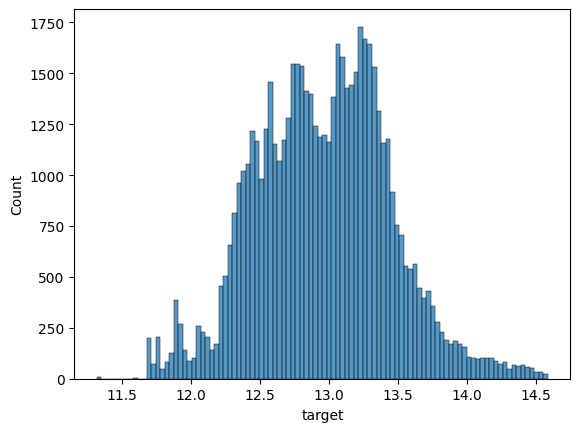

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["target"], bins=100)
plt.show()

In [22]:
X = df.drop(columns=["PricePerMeter", "target"])
y = df["target"]

print("Feature shape:", X.shape)

Feature shape: (58716, 30)


In [23]:
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Categorical Features:")
print(cat_features)
print("Count:", len(cat_features))

Categorical Features:
['District', 'Class', 'Building', 'HandoverDate', 'BuildingType', 'Section', 'PropertyType', 'PropertyCategory', 'Apartments', 'Finishing', 'Status', 'ApartmentOption', 'Mortgage', 'Subsidies', 'Layout', 'Developer_encoded', 'Complex_encoded']
Count: 17


In [24]:
X.isnull().sum().sort_values(ascending=False).head(10)

District        0
Class           0
Building        0
FloorsTotal     0
HandoverDate    0
Phase           0
BuildingType    0
Floor           0
Section         0
PropertyType    0
dtype: int64

In [25]:
for col in cat_features:
    print(col, "→ unique:", X[col].nunique())

District → unique: 111
Class → unique: 4
Building → unique: 498
HandoverDate → unique: 19
BuildingType → unique: 6
Section → unique: 78
PropertyType → unique: 15
PropertyCategory → unique: 8
Apartments → unique: 2
Finishing → unique: 6
Status → unique: 1
ApartmentOption → unique: 2
Mortgage → unique: 2
Subsidies → unique: 2
Layout → unique: 2
Developer_encoded → unique: 109
Complex_encoded → unique: 395


In [26]:
print("Total missing in X:", X.isnull().sum().sum())

Total missing in X: 0


In [27]:
X = X.fillna("Missing")

# For numeric columns, convert back properly
num_cols = X.select_dtypes(include=["float64", "int64"]).columns
for col in num_cols:
    X[col] = pd.to_numeric(X[col], errors="coerce")

X = X.fillna(0)

In [28]:
print("Missing in y:", y.isnull().sum())

Missing in y: 0


In [29]:
cat_feature_indices = [X.columns.get_loc(col) for col in cat_features]
print(cat_feature_indices)

[0, 1, 2, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 28, 29]


In [30]:
for col in cat_features:
    X[col] = X[col].astype("category")

In [31]:
print("Min PricePerMeter:", df["PricePerMeter"].min())
print("Max PricePerMeter:", df["PricePerMeter"].max())
print("Any zeros:", (df["PricePerMeter"] == 0).sum())
print("Any negative:", (df["PricePerMeter"] < 0).sum())

Min PricePerMeter: 0.0
Max PricePerMeter: 2165000.0
Any zeros: 4
Any negative: 0


In [32]:
print("Target min:", df["target"].min())
print("Target max:", df["target"].max())

Target min: -inf
Target max: 14.587930919418728


In [33]:
df = df[df["PricePerMeter"] > 0]

In [34]:
df["target"] = np.log(df["PricePerMeter"])

In [35]:
print("Target min:", df["target"].min())
print("Target max:", df["target"].max())

Target min: 11.318029176594122
Target max: 14.587930919418728


In [36]:
X = df.drop(columns=["PricePerMeter", "target"])
y = df["target"]

In [37]:
for col in cat_features:
    X[col] = X[col].astype("category")

In [38]:
print("Any -inf in target:", np.isinf(y).sum())
print("Target min:", y.min())

Any -inf in target: 0
Target min: 11.318029176594122


In [39]:
# Remove problematic column
if "HandoverDate" in X.columns:
    X = X.drop(columns=["HandoverDate"])

# Also remove from categorical list if present
cat_features = [col for col in cat_features if col != "HandoverDate"]

print("HandoverDate removed.")

HandoverDate removed.


In [40]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [41]:
import json

feature_list = list(X.columns)

with open("model_features.json", "w") as f:
    json.dump(feature_list, f)

print("Feature list saved.")

Feature list saved.


In [42]:
X = df.drop(columns=["PricePerMeter", "target"])
y = df["target"]

In [43]:
print(X.columns)

Index(['District', 'Class', 'Building', 'FloorsTotal', 'HandoverDate', 'Phase',
       'BuildingType', 'Floor', 'Section', 'PropertyType', 'PropertyCategory',
       'Apartments', 'Finishing', 'Status', 'ApartmentOption', 'Mortgage',
       'Subsidies', 'Layout', 'CeilingHeight', 'TotalArea',
       'AreaWithoutBalcony', 'LivingArea', 'KitchenArea', 'HallwayArea',
       'BathroomArea', 'BalconyArea', 'PlotArea', 'TotalCost',
       'Developer_encoded', 'Complex_encoded'],
      dtype='object')


In [44]:
X = X.drop(columns=["HandoverDate"], errors="ignore")

In [45]:
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [47]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=42,
    early_stopping_rounds=100,
    verbose=100
)

model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
    cat_features=cat_features
)

0:	learn: 0.4701844	test: 0.4661524	best: 0.4661524 (0)	total: 205ms	remaining: 3m 24s
100:	learn: 0.0881276	test: 0.0864450	best: 0.0864450 (100)	total: 5.63s	remaining: 50.1s


KeyboardInterrupt: 

In [48]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

preds_log = model.predict(X_test)
preds = np.exp(preds_log)
y_true = np.exp(y_test)

mae = mean_absolute_error(y_true, preds)
rmse = np.sqrt(mean_squared_error(y_true, preds))
r2 = r2_score(y_true, preds)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

CatBoostError: There is no trained model to use predict(). Use fit() to train model. Then use this method.

In [ ]:
print(df["PricePerMeter"].mean())

479970.51611024485


In [ ]:
explainer = shap.TreeExplainer(model)
sample = X_test.iloc[0:1]
shap_values = explainer.shap_values(sample)

shap_df = pd.DataFrame({
    "feature": X.columns,
    "impact": shap_values[0]
}).sort_values(by="impact", key=abs, ascending=False)

shap_df.head(10)

,feature,impact
0,District,0.204614
27,Complex_encoded,0.113998
17,CeilingHeight,0.112592
18,TotalArea,-0.045909
26,Developer_encoded,-0.018980
4,Phase,0.014680
9,PropertyCategory,0.010977
6,Floor,-0.007619
11,Finishing,-0.007414
3,FloorsTotal,0.006995


In [ ]:
model.save_model("catboost_price_model_final.cbm")

In [ ]:
import numpy as np

sample = X_test.iloc[0].to_dict()

pred_log = model.predict(pd.DataFrame([sample]))
pred_price = np.exp(pred_log)[0]

actual_price = np.exp(y_test.iloc[0])

print("Predicted PricePerMeter:", round(pred_price, 2))
print("Actual PricePerMeter:", round(actual_price, 2))
print("Absolute Error:", round(abs(pred_price - actual_price), 2))

Predicted PricePerMeter: 631780.16
Actual PricePerMeter: 666475.01
Absolute Error: 34694.85


In [ ]:
print("Final feature count:", len(X.columns))
print(X.columns.tolist())

Final feature count: 28
['District', 'Class', 'Building', 'FloorsTotal', 'Phase', 'BuildingType', 'Floor', 'Section', 'PropertyType', 'PropertyCategory', 'Apartments', 'Finishing', 'Status', 'ApartmentOption', 'Mortgage', 'Subsidies', 'Layout', 'CeilingHeight', 'TotalArea', 'AreaWithoutBalcony', 'LivingArea', 'KitchenArea', 'HallwayArea', 'BathroomArea', 'BalconyArea', 'PlotArea', 'Developer_encoded', 'Complex_encoded']


In [ ]:
import json

final_features = list(X.columns)

with open("model_features.json", "w") as f:
    json.dump(final_features, f, indent=4)

print("Updated model_features.json saved.")

Updated model_features.json saved.


In [ ]:
import json

with open("categorical_features.json", "w") as f:
    json.dump(cat_features, f)

print("categorical_features.json saved.")

NameError: name 'cat_features' is not defined

In [49]:
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Categorical features:")
print(cat_features)
print("Count:", len(cat_features))

Categorical features:
['District', 'Class', 'Building', 'BuildingType', 'Section', 'PropertyType', 'PropertyCategory', 'Apartments', 'Finishing', 'Status', 'ApartmentOption', 'Mortgage', 'Subsidies', 'Layout', 'Developer_encoded', 'Complex_encoded']
Count: 16


In [50]:
import json

with open("categorical_features.json", "w") as f:
    json.dump(cat_features, f, indent=4)

print("categorical_features.json saved successfully.")

categorical_features.json saved successfully.
